In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import sys

from scipy import stats

N_SYNTH = 200
LO = .05
HI = .95
NBINS = 20
NUM_ARGS = 4

def predict(mcmc_samples, s_test_idx, d_test_idx):
    assert len(s_test_idx) == len(d_test_idx)
    n = len(s_test_idx)
    # read in mcmc samples for each variable
    s = np.array(mcmc_samples['s']) 
    d = np.array(mcmc_samples['d'])
    a = np.array(mcmc_samples['a'])
    a_s = np.array(mcmc_samples['a_s'])
    a_d = np.array(mcmc_samples['a_d'])
    # combine above matrices to create mu
    m = s.shape[0]
    mu = np.multiply(s[0:m, s_test_idx], d[0:m, d_test_idx]) + a_s[0:m, s_test_idx] + a_d[0:m, d_test_idx] + a
    assert (mu.shape[0] == m) and (mu.shape[1] == n)
    return mu

def r_squared(mu, test):
    means = np.mean(mu, axis=0)
    assert means.shape[0] == test.shape[0]
    pearson_corr = np.corrcoef(test, means)
    r = pearson_corr[0, 1]
    return np.power(r, 2)

# function to compute coverage
def coverage(mu, test, n_synth, hi, lo):
    # generate synthetic samples from normal distribution with mean mu
    m = mu.shape[0]
    n = mu.shape[1]
    mean = np.tile(mu, (n_synth, 1, 1))
    synth = mean + np.random.normal(loc=0, scale=1, size=(n_synth, m, n))
    # sort along synthetic axis
    sorted_synth = np.sort(synth, axis=0)
    # compute hi and lo index
    lo_idx = int(np.ceil(lo * n_synth))
    hi_idx = int(np.floor(hi * n_synth))
    # get synthetic samples at hi and lo indices
    lo_bound = sorted_synth[lo_idx, :, :]
    hi_bound = sorted_synth[hi_idx, :, :]
    # is test in [hi, lo]?
    tiled_test = np.tile(test, (m, 1))
    return np.sum((lo_bound < tiled_test) & (tiled_test < hi_bound), axis=1) / (1.0 * len(test))


mcmc_samples_fn = '../results/2023-06-08/run_model/mcmc_samples.pkl'
test_fn = '../results/2023-06-08/clean_and_split_data/split/test.pkl'

# read in mcmc samples
with open(mcmc_samples_fn, 'rb') as handle:
    mcmc_samples = pickle.load(handle)
    
# reach in test data
with open(test_fn, 'rb') as handle:
    test_df = pickle.load(handle)

In [11]:
mcmc_samples[0]

KeyError: 0

In [2]:
test = test_df['log(V_V0)'].to_numpy().astype(float)
# get mcmc_samples, s_test_idx, d_test_idx
s_test_idx = test_df['s_idx'].to_numpy()
d_test_idx = test_df['d_idx'].to_numpy()
mu = predict(mcmc_samples, s_test_idx, d_test_idx)

r-squared: 0.008762352081759637
mean fracs: 0.48015625
median fracs: 0.4765625


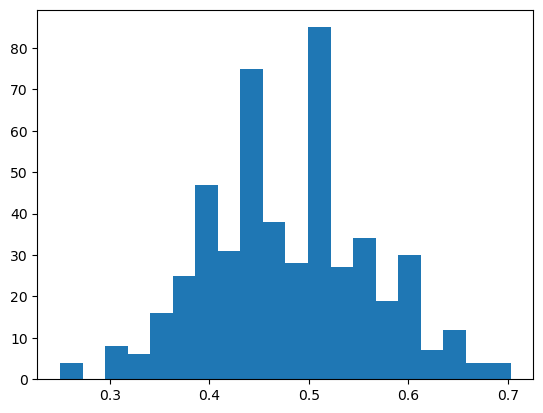

In [8]:
r_sq = r_squared(mu, test)
fracs = coverage(mu, test, N_SYNTH, HI, LO)
# produce plot w/ fracs, r_sq
print('r-squared: ' + str(r_sq))
plt.hist(fracs, bins=NBINS)
print('mean fracs: ' + str(np.mean(fracs)))
print('median fracs: ' + str(np.median(fracs)))